# Lista 3: Dobre praktyki

In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Definiujemy transformacje
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

Wyświetlmy przykładowe obrazy:

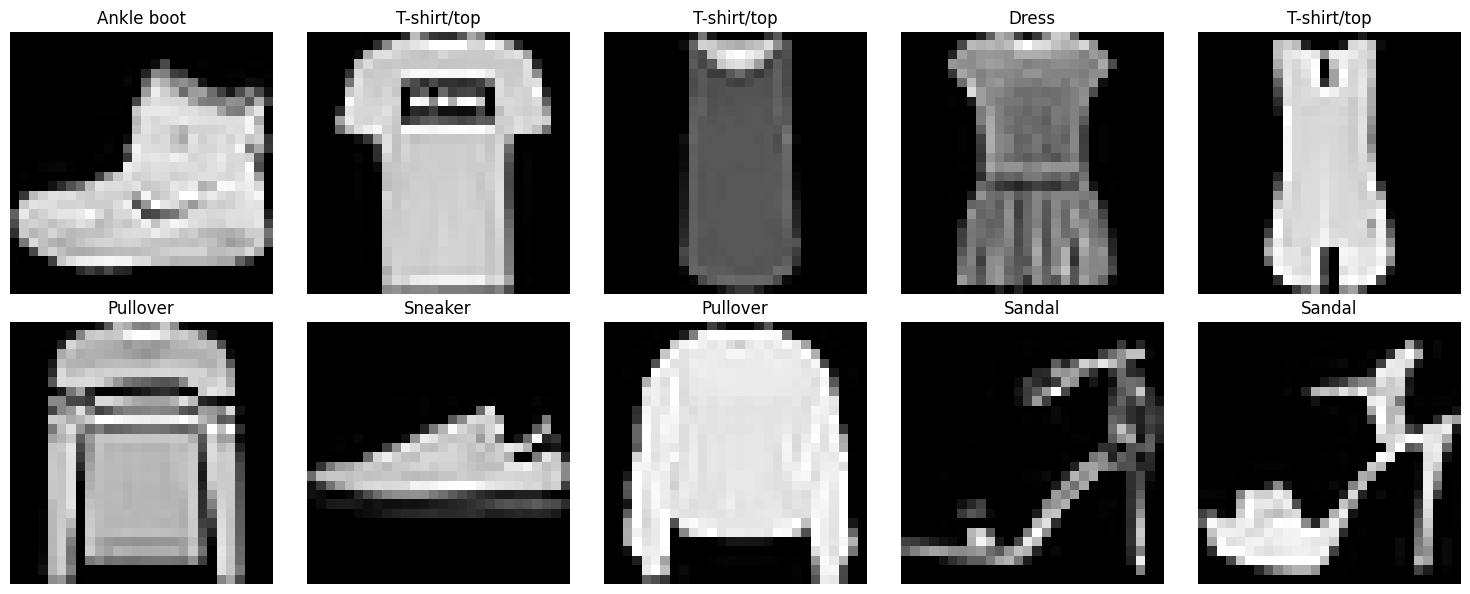

In [2]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img, label = trainset[i]
    img = img.numpy().squeeze()
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{class_names[label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Wypiszmy jeszcze do tego może jakieś informacje o tych zdjęciach

In [3]:
print(f"Liczba obrazów treningowych: {len(trainset)}")
print(f"Liczba obrazów testowych: {len(testset)}")

img, label = trainset[0]
print(f"\nKształt tensora obrazu: {img.shape}")
print(f"Typ danych: {img.dtype}")
print(f"Zakres wartości: min={img.min():.3f}, max={img.max():.3f}")

from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)
print(f"\nRozkład klas w zbiorze treningowym:")
for i, count in sorted(label_counts.items()):
    print(f"  {class_names[i]}: {count} obrazów")


Liczba obrazów treningowych: 60000
Liczba obrazów testowych: 10000

Kształt tensora obrazu: torch.Size([1, 28, 28])
Typ danych: torch.float32
Zakres wartości: min=0.000, max=1.000

Rozkład klas w zbiorze treningowym:
  T-shirt/top: 6000 obrazów
  Trouser: 6000 obrazów
  Pullover: 6000 obrazów
  Dress: 6000 obrazów
  Coat: 6000 obrazów
  Sandal: 6000 obrazów
  Shirt: 6000 obrazów
  Sneaker: 6000 obrazów
  Bag: 6000 obrazów
  Ankle boot: 6000 obrazów


klasy są równiótko podzielone, żadna nie odstaje ilościowo od reszty, zdjęcie to jest w skali szarości i ma wymiary 28 na 28 no i jest 10 etykiet (różnych rodzajów odzieży)

In [4]:
# Dataloadery
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_set, valset = random_split(trainset, [train_size, val_size])

batch_size = 64
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=use_cuda
)

val_loader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=use_cuda
)

test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=use_cuda
)

### Model
W celu przeszukiwania optymalnych hiperparametrów modelu, stwowrzymy klasę ParameterizedMLP, która stworzy nam model MLP przy zadanych wartościach. Chcemy móc w łatwy sposób zmieniać dropout, liczbę warstw oraz liczbę neuronów w tych warstwach, oraz możliwość użycia batch normalization wraz z wyborem funkcji aktywacji.

In [5]:
class ParameterizedMLP(torch.nn.Module):                                      # 28x28 zdjęcie      10 klas
    def __init__(self, hidden_layers, use_batch_norm=False, dropout_rate=0.0, input_size=28*28, output_size=10, activation_fn=torch.nn.ReLU()):
        super().__init__()
        
        layers = []
        current_input_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            layers.append(torch.nn.Linear(current_input_size, layer_size))
            
            if use_batch_norm:
                layers.append(torch.nn.BatchNorm1d(layer_size))
            
            layers.append(activation_fn)

            if dropout_rate > 0:
                layers.append(torch.nn.Dropout(p=dropout_rate))
            
            current_input_size = layer_size
    
        layers.append(torch.nn.Linear(current_input_size, output_size))
        
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


Dla powtarzalności wyników ustawimy sobie ziarno

In [6]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Trenowanie modelu
Stworzymy sobie funkcję do trenowania modelu. Na wejściu dajemy model zrobiony z klasy powyżej, dodajemy dane z dataloadera i od razu ustawiamy sobie do wyboru do koloru liczbę epok, optimizer, funkcję straty oraz patience dla early stoppingu. W pętli treningowej od razu też zliczamy accuracy oraz wartość loss z zarówno zbioru treningowego jak i walidacyjnego. Dodajemy też możliwość ustawienia cosine lr scheduling, oraz dodania regularyzacji l1,l2

In [7]:
def train_model(model, train_loader, val_loader, test_loader, epochs, optimizer, loss_fn, patience, model_save_path, scheduler=None, l1_lambda=0.0, l2_lambda=0.0,early_stopping=True,print_logs=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0


  #  Trening 
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)

             # Regularyzacja L1
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm

            # Regularyzacja L2
            if l2_lambda > 0:
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += l2_lambda * l2_norm

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / len(train_loader.dataset)

        if scheduler:
            scheduler.step()

        # Walidacja 
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)
        if print_logs:
            print(f"Epoka {epoch+1}/{epochs} | "
                f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
                f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        #  Early Stopping i zapis modelu 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            if print_logs:
                print(f"Najlepsza strata walidacyjna: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and early_stopping:
                print(f"Koniec treningu na epoce {epoch+1}. Brak poprawy przez {patience} epok."
                      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
                      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                break
        if not print_logs and epoch == epochs - 1:
            print(f"Ostatnia epoka treningu:"
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    #  Ewaluacja 
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / len(test_loader.dataset)
    print("-" * 30)
    print(f"Wyniki na zbiorze testowym:")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
    print("-" * 30)
    return best_val_loss

Ustawmy jakieś początkowe parametry dla naszej sieci

In [8]:
epochs = 50
learning_rate = 0.001
patience = 5
model_save_path = "best_model.pth"
hidden_layers = [256, 128, 64]
dropout = 0.2
batch_norm = True
l1 = 0.0
l2 = 0.0
activation_fn = torch.nn.ReLU()

In [9]:
# inicjalizacja modelu
model = ParameterizedMLP(
    hidden_layers=hidden_layers,
    use_batch_norm=batch_norm,
    dropout_rate=dropout,
    activation_fn=activation_fn
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Zobaczmy jaki wynik osiągnie model z takimi hiperparametrami na start

In [10]:
train_model(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    optimizer=optimizer,
    loss_fn=loss_fn,
    patience=patience,
    model_save_path=model_save_path,
    scheduler=scheduler,
    l1_lambda=l1,
    l2_lambda=l2
)

Epoka 1/50 | Train Loss: 0.5929, Train Acc: 0.8086 | Val Loss: 0.3952, Val Acc: 0.8567
Najlepsza strata walidacyjna: 0.3952
Epoka 2/50 | Train Loss: 0.4235, Train Acc: 0.8489 | Val Loss: 0.3478, Val Acc: 0.8718
Najlepsza strata walidacyjna: 0.3478
Epoka 3/50 | Train Loss: 0.3846, Train Acc: 0.8623 | Val Loss: 0.3338, Val Acc: 0.8749
Najlepsza strata walidacyjna: 0.3338
Epoka 4/50 | Train Loss: 0.3614, Train Acc: 0.8701 | Val Loss: 0.3358, Val Acc: 0.8767
Epoka 5/50 | Train Loss: 0.3431, Train Acc: 0.8770 | Val Loss: 0.3023, Val Acc: 0.8861
Najlepsza strata walidacyjna: 0.3023
Epoka 6/50 | Train Loss: 0.3273, Train Acc: 0.8829 | Val Loss: 0.2997, Val Acc: 0.8874
Najlepsza strata walidacyjna: 0.2997
Epoka 7/50 | Train Loss: 0.3131, Train Acc: 0.8880 | Val Loss: 0.3128, Val Acc: 0.8857
Epoka 8/50 | Train Loss: 0.3013, Train Acc: 0.8918 | Val Loss: 0.2957, Val Acc: 0.8900
Najlepsza strata walidacyjna: 0.2957
Epoka 9/50 | Train Loss: 0.2916, Train Acc: 0.8930 | Val Loss: 0.3057, Val Acc: 0.

0.26763154677254086

Model coś tam się nawet uczy przelećmy teraz przez wszystkie parametry i zobaczmy co można poprawić

## Optymalizacja:

1. Early stopping

    Porównajmy sobie jak model poradzi sobie z oraz bez early stoppingu
    wersja z early stoppingiem była użyta powyżej więc teraz po prostu zrobimy bez niego i porównamy wyniki

In [11]:
train_model(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    optimizer=optimizer,
    loss_fn=loss_fn,
    patience=patience,
    model_save_path=model_save_path,
    scheduler=scheduler,
    l1_lambda=l1,
    l2_lambda=l2,
    early_stopping=False,   # wyłączamy early stopping
    print_logs=False
)

Ostatnia epoka treningu:Train Loss: 0.1323, Train Acc: 0.9507 | Val Loss: 0.3092, Val Acc: 0.9015
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3026, Test Acc: 0.8940
------------------------------


0.27008441043026904

Możemy od razu zauważyć, że model się przeucza, bo bez early stoppingu, acuracy rośnie, ale zbiór testowy daje identyczny wynik co model z early  stoppingiem. Overfittingiem zajmiemy się zaraz, ale na tym etapie myślę, że ograniczenie liczby epok poprzez wprowadzenie ES nie jest głupie, ewentualnie możnaby rozważyć zwiększenie cierpliwości.

In [12]:
patience = 10

2. architektura sieci

    przetestujemy 3 warianty: 
    - architektura mała:
    - architektura duża:
    - architektura "na oko"

In [13]:
arch_1 = [32,16]    # mała sieć
arch_2 = [256, 128, 64]  # średnia sieć
arch_3 = [1024, 512, 256, 128, 64, 32, 16] # duża sieć

model1 = ParameterizedMLP(
    hidden_layers=arch_1,
    use_batch_norm=True,
    dropout_rate=0.2,
    activation_fn=activation_fn,
)

model2 = ParameterizedMLP(
    hidden_layers=arch_2,
    use_batch_norm=True,
    dropout_rate=0.2,
    activation_fn=activation_fn,
)

model3 = ParameterizedMLP(
    hidden_layers=arch_3,
    use_batch_norm=True,
    dropout_rate=0.2,
    activation_fn=activation_fn,
)

In [14]:
print("Architektura 1: [32,16]")
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
train_model(
    model=model1,
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    optimizer=optimizer1,
    loss_fn=loss_fn,
    patience=patience,
    model_save_path=model_save_path,
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=epochs),
    l1_lambda=l1,
    l2_lambda=l2, 
    print_logs=False
)
print("\n" + "="*50 + "\n")

print("Architektura 2: [256,128,64]")
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
train_model(
    model=model2,
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    optimizer=optimizer2,
    loss_fn=loss_fn,
    patience=patience,
    model_save_path=model_save_path,
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=epochs),
    l1_lambda=l1,
    l2_lambda=l2, 
    print_logs=False
)
print("\n" + "="*50 + "\n")

print("Architektura 3: [1024,512,256,128,64,32,16]")
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
train_model(
    model=model3,
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=epochs,
    optimizer=optimizer3,
    loss_fn=loss_fn,
    patience=patience,
    model_save_path=model_save_path,
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=epochs),
    l1_lambda=l1,
    l2_lambda=l2, 
    print_logs=False
)

Architektura 1: [32,16]


Koniec treningu na epoce 41. Brak poprawy przez 10 epok.Train Loss: 0.3879, Train Acc: 0.8607 | Val Loss: 0.3346, Val Acc: 0.8818
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3689, Test Acc: 0.8671
------------------------------


Architektura 2: [256,128,64]
Koniec treningu na epoce 29. Brak poprawy przez 10 epok.Train Loss: 0.1538, Train Acc: 0.9425 | Val Loss: 0.2848, Val Acc: 0.9063
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3045, Test Acc: 0.8939
------------------------------


Architektura 3: [1024,512,256,128,64,32,16]
Koniec treningu na epoce 36. Brak poprawy przez 10 epok.Train Loss: 0.1893, Train Acc: 0.9386 | Val Loss: 0.3118, Val Acc: 0.9051
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3299, Test Acc: 0.8968
------------------------------


0.2901574750529959

Jak widać, wyniki nie różnią się od siebie za bardzo, mała sieć uczy się trochę słabiej, najwidoczniej ma za mało warst żeby rozpoznać wszystkie patterny, ale różnica między architekturą na oko oraz dużą nie istnieje, więc zostaniemy przy tej średniej, bo duża o wiele więcej czasu pochłania nie dając lepszych wyników.  Liczba warstw tutaj nie ma aż takiego znaczenia prawdopodobnie przez to że sam przykład jest stosunkowo prosty, a dataset jest bardzo czysty i przygotowany więc nie ma co głębiej szukać tutaj. 

3. regularyzacja i dropout

    Tutaj wykorzystamy bibliotekę optuna, która powinna znaleźć odpowiednią wartość tych dwóch hiperparametrów

In [15]:
import optuna

def objective(trial):
    
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.6)
    reg_type = trial.suggest_categorical("reg_type", ["None", "L1", "L2"])
    
    l1_lambda = 0.0
    l2_lambda = 0.0
     
    if reg_type == "L1":
        l1_lambda = trial.suggest_float("l1_lambda", 1e-6, 1e-2, log=True)
    elif reg_type == "L2":
        l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-2, log=True)

    
    model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=True,
        dropout_rate=dropout_rate,
        activation_fn=torch.nn.ReLU()
    )
   
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    val_loss = train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=20, # na potrzeby testów zmniejszamy liczbę epok
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=5,
        model_save_path="optuna_reg_test.pth",
        scheduler=scheduler,
        l1_lambda=l1_lambda,
        l2_lambda=l2_lambda,
        print_logs=False,
        early_stopping=True
    )
    
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15) 

print("Najlepsze parametry:")
print(study.best_params)

# Wizualizacja ważności parametrów 
optuna.visualization.plot_param_importances(study).show()

# Wizualizacja zależności 
optuna.visualization.plot_slice(study).show()

c:\Users\RODO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-12 14:33:16,243] A new study created in memory with name: no-name-1c0ba16d-00ed-4b16-bbb1-cc9784a2332e


Ostatnia epoka treningu:Train Loss: 0.2581, Train Acc: 0.9330 | Val Loss: 0.2584, Val Acc: 0.9070


[I 2026-01-12 14:36:37,922] Trial 0 finished with value: 0.25761873225503146 and parameters: {'dropout_rate': 0.17549998013163756, 'reg_type': 'L1', 'l1_lambda': 8.615706955670253e-06}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2913, Test Acc: 0.8989
------------------------------
Ostatnia epoka treningu:Train Loss: 0.3701, Train Acc: 0.8765 | Val Loss: 0.2964, Val Acc: 0.8909


[I 2026-01-12 14:39:04,887] Trial 1 finished with value: 0.29604384675621986 and parameters: {'dropout_rate': 0.531974229972328, 'reg_type': 'None'}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3338, Test Acc: 0.8827
------------------------------
Ostatnia epoka treningu:Train Loss: 1.1591, Train Acc: 0.8163 | Val Loss: 0.4319, Val Acc: 0.8542


[I 2026-01-12 14:41:59,984] Trial 2 finished with value: 0.43185235266672806 and parameters: {'dropout_rate': 0.3513412988171633, 'reg_type': 'L1', 'l1_lambda': 0.003354322856564277}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.4548, Test Acc: 0.8451
------------------------------
Ostatnia epoka treningu:Train Loss: 0.4179, Train Acc: 0.9058 | Val Loss: 0.2680, Val Acc: 0.9006


[I 2026-01-12 14:45:00,051] Trial 3 finished with value: 0.2679641235699045 and parameters: {'dropout_rate': 0.13768612735179137, 'reg_type': 'L1', 'l1_lambda': 0.00010937743562713039}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2977, Test Acc: 0.8900
------------------------------
Koniec treningu na epoce 17. Brak poprawy przez 5 epok.Train Loss: 0.0886, Train Acc: 0.9683 | Val Loss: 0.2994, Val Acc: 0.9067


[I 2026-01-12 14:47:08,637] Trial 4 finished with value: 0.2842021843299587 and parameters: {'dropout_rate': 0.011581565260267124, 'reg_type': 'None'}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3143, Test Acc: 0.8965
------------------------------
Ostatnia epoka treningu:Train Loss: 0.4040, Train Acc: 0.8720 | Val Loss: 0.3041, Val Acc: 0.8863


[I 2026-01-12 14:50:15,422] Trial 5 finished with value: 0.30410984063402136 and parameters: {'dropout_rate': 0.5640322395759447, 'reg_type': 'L2', 'l2_lambda': 6.5016541920275665e-06}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3367, Test Acc: 0.8800
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2293, Train Acc: 0.9160 | Val Loss: 0.2630, Val Acc: 0.9035


[I 2026-01-12 14:52:50,500] Trial 6 finished with value: 0.2620878194835275 and parameters: {'dropout_rate': 0.296611177067488, 'reg_type': 'None'}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2973, Test Acc: 0.8950
------------------------------
Ostatnia epoka treningu:Train Loss: 0.3321, Train Acc: 0.9057 | Val Loss: 0.2682, Val Acc: 0.9018


[I 2026-01-12 14:55:54,542] Trial 7 finished with value: 0.2681842067060953 and parameters: {'dropout_rate': 0.3819155838777855, 'reg_type': 'L2', 'l2_lambda': 5.3367138027746526e-05}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3001, Test Acc: 0.8927
------------------------------
Ostatnia epoka treningu:Train Loss: 0.3534, Train Acc: 0.8985 | Val Loss: 0.2757, Val Acc: 0.8961


[I 2026-01-12 14:58:54,799] Trial 8 finished with value: 0.27533126979115163 and parameters: {'dropout_rate': 0.4089209236026055, 'reg_type': 'L1', 'l1_lambda': 5.730987538179275e-06}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3119, Test Acc: 0.8880
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2977, Train Acc: 0.8970 | Val Loss: 0.2778, Val Acc: 0.8957


[I 2026-01-12 15:01:29,547] Trial 9 finished with value: 0.276797215117419 and parameters: {'dropout_rate': 0.4250265171078751, 'reg_type': 'None'}. Best is trial 0 with value: 0.25761873225503146.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3149, Test Acc: 0.8883
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2130, Train Acc: 0.9302 | Val Loss: 0.2577, Val Acc: 0.9061


[I 2026-01-12 15:04:22,452] Trial 10 finished with value: 0.2576045389188097 and parameters: {'dropout_rate': 0.2179403365420487, 'reg_type': 'L1', 'l1_lambda': 1.6031053581012928e-06}. Best is trial 10 with value: 0.2576045389188097.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2967, Test Acc: 0.8969
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2051, Train Acc: 0.9303 | Val Loss: 0.2598, Val Acc: 0.9073


[I 2026-01-12 15:07:13,371] Trial 11 finished with value: 0.2598229678783645 and parameters: {'dropout_rate': 0.21072702413272154, 'reg_type': 'L1', 'l1_lambda': 1.1214172196101204e-06}. Best is trial 10 with value: 0.2576045389188097.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2916, Test Acc: 0.8987
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2699, Train Acc: 0.9355 | Val Loss: 0.2572, Val Acc: 0.9058


[I 2026-01-12 15:10:02,354] Trial 12 finished with value: 0.2563697268908962 and parameters: {'dropout_rate': 0.15463322654513284, 'reg_type': 'L1', 'l1_lambda': 1.3025980271889521e-05}. Best is trial 12 with value: 0.2563697268908962.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2908, Test Acc: 0.8992
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2828, Train Acc: 0.9389 | Val Loss: 0.2617, Val Acc: 0.9058


[I 2026-01-12 15:12:52,937] Trial 13 finished with value: 0.261687053446757 and parameters: {'dropout_rate': 0.0675882073811544, 'reg_type': 'L1', 'l1_lambda': 3.1144459637251205e-05}. Best is trial 12 with value: 0.2563697268908962.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2875, Test Acc: 0.8999
------------------------------
Ostatnia epoka treningu:Train Loss: 0.2399, Train Acc: 0.9205 | Val Loss: 0.2611, Val Acc: 0.9041


[I 2026-01-12 15:15:44,559] Trial 14 finished with value: 0.26109180650971037 and parameters: {'dropout_rate': 0.2575660406730091, 'reg_type': 'L1', 'l1_lambda': 1.7518248487473925e-06}. Best is trial 12 with value: 0.2563697268908962.


------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2983, Test Acc: 0.8958
------------------------------
Najlepsze parametry:
{'dropout_rate': 0.15463322654513284, 'reg_type': 'L1', 'l1_lambda': 1.3025980271889521e-05}


Z jakiegoś powodu jupyter nie chce wyświetlić wykresów więc wrzucam je tutaj:
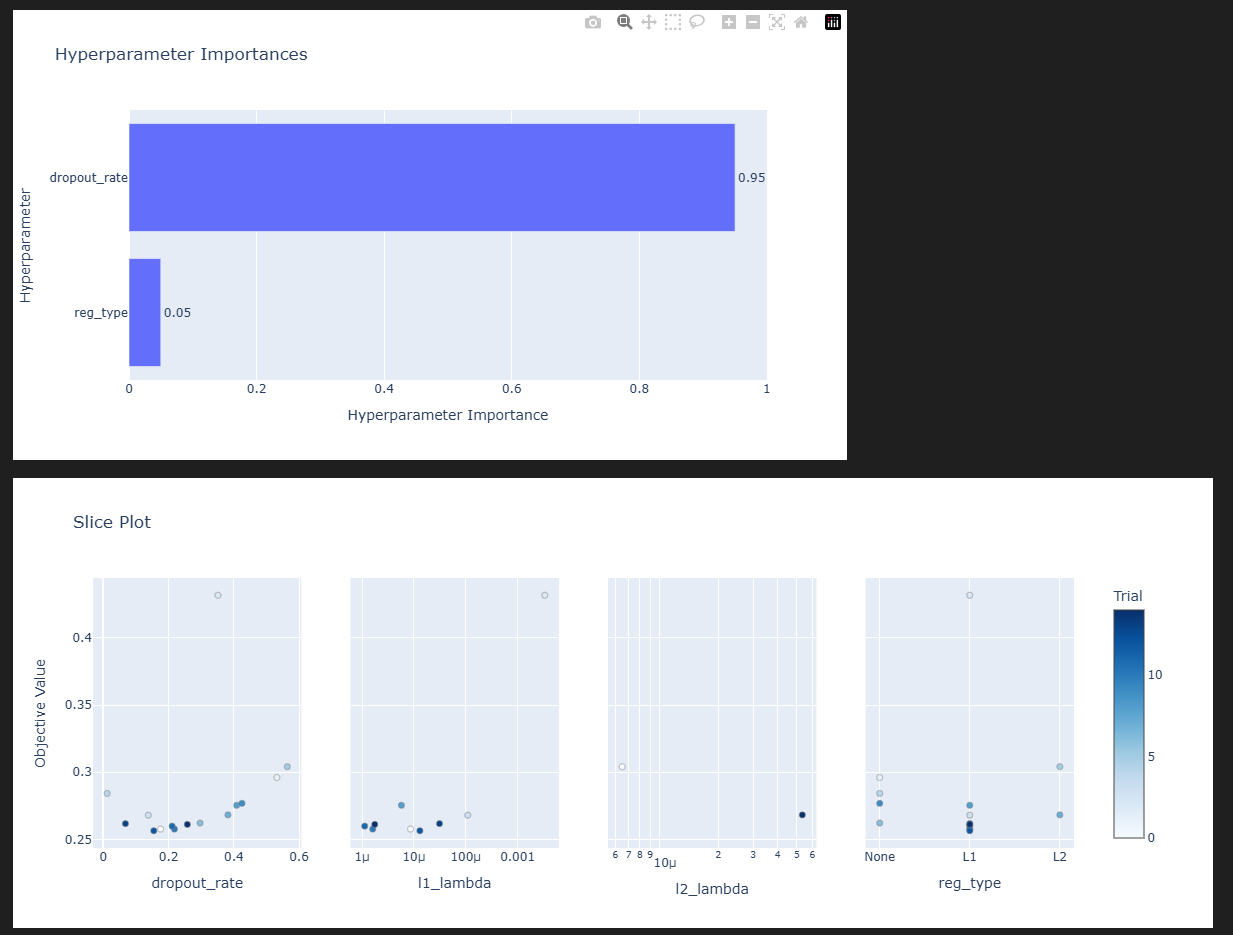

Z wykresów można odczytać, że rodzaj regularyzacji nie miał za bardzo wpływu na jakość uczenia, w porównaniu do dropoutu. SLice plot nam ładnie pokazuje, że wartości dropoutu zbliżają się do okolic 0.2 (optuna stara się minimalizować stratę na zbiorze walidacyjnym dlatego im niżej tym lepiej) a regresja powinna być wyłączona.

In [16]:
l1 = 0.0
l2 = 0.0
dropout = 0.2

4. Scheduling lr,  batchnorm, optymalizator i funkcje wejścia oraz straty

    Tutaj po prostu porównamy sobie trenowanie z i bez batchnorm i scheduling lr, oraz przetestujemy kilka różnych  funkcji wejścia oraz straty

### Scheduling rate:
Na początek odpalmy bez niego:

In [17]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=False,
        dropout_rate=dropout,
        activation_fn=torch.nn.ReLU()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = None

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True
    )

Koniec treningu na epoce 32. Brak poprawy przez 10 epok.Train Loss: 0.2194, Train Acc: 0.9179 | Val Loss: 0.3161, Val Acc: 0.8882
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3251, Test Acc: 0.8848
------------------------------


0.28989396359216657

I wersja z

In [18]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=False,
        dropout_rate=dropout,
        activation_fn=torch.nn.ReLU()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True
    )

Koniec treningu na epoce 29. Brak poprawy przez 10 epok.Train Loss: 0.2263, Train Acc: 0.9149 | Val Loss: 0.2956, Val Acc: 0.8980
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3203, Test Acc: 0.8903
------------------------------


0.27867467103010796

Scheduler nieco poprawia wynik więc go zostawiamy

### Batch norm
wcześniejsze treningi były bez batchnorm, więc teraz włączymy i zobaczymy jak to wygląda

In [19]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=True,
        dropout_rate=dropout,
        activation_fn=torch.nn.ReLU()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True
    )

Koniec treningu na epoce 30. Brak poprawy przez 10 epok.Train Loss: 0.1991, Train Acc: 0.9260 | Val Loss: 0.2727, Val Acc: 0.9054
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.2911, Test Acc: 0.8997
------------------------------


0.26003025432533405

Dodanie batchnorma daje nam 0.7 punkta procentowego więcej do accuracy więc jego ustawiamy go na True

### F.aktywacji
Dotychczas używaliśmy Funkcji Relu, zmieńmy ją teraz na sigmoid

In [20]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=True,
        dropout_rate=dropout,
        activation_fn=torch.nn.Sigmoid()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True)

Ostatnia epoka treningu:Train Loss: 0.2117, Train Acc: 0.9220 | Val Loss: 0.2958, Val Acc: 0.8956
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3283, Test Acc: 0.8824
------------------------------


0.28980015955389815

wynik słabszy, dodatkowo możemy też sprawdzić tahn

In [21]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=True,
        dropout_rate=dropout,
        activation_fn=torch.nn.Tanh()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True)

Koniec treningu na epoce 33. Brak poprawy przez 10 epok.Train Loss: 0.2524, Train Acc: 0.9095 | Val Loss: 0.3027, Val Acc: 0.8939
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.3199, Test Acc: 0.8876
------------------------------


0.28217652753154016

No tutaj bez większego zdziwienia Relu wygrywa. Sigmoid nie poradził sobie zbyt dobrze, głównie dlatego że przy małych zmianach nie działa on za dobrze, zaokrąglając do 0 i 1

### F. straty
Sprawdźmy jak zadziała Focal loss zamiast wcześniej użytej entropii krzyżowej. 

In [22]:
import torch.nn as nn   # nie ma wbudowanej funkcji Focal Loss w PyTorch
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # float lub Tensor[num_classes]
        self.reduction = reduction

    def forward(self, logits, targets):
        # logit shape: [B, C], targets: [B]
        log_probs = F.log_softmax(logits, dim=1)
        probs = log_probs.exp()
        pt = probs[torch.arange(targets.size(0), device=targets.device), targets]  # p_t
        ce = F.nll_loss(log_probs, targets, reduction='none')  # -log(p_t)

        loss = ((1 - pt) ** self.gamma) * ce

        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                loss = self.alpha.to(logits.device)[targets] * loss
            else:
                loss = float(self.alpha) * loss

        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

In [23]:
model = ParameterizedMLP(
        hidden_layers=[256, 128, 64], 
        use_batch_norm=True,
        dropout_rate=dropout,
        activation_fn=torch.nn.ReLU()
    )
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_model(
        model=model,
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs, 
        optimizer=optimizer,
        loss_fn=FocalLoss(),
        patience=10,
        model_save_path="best_model.pth",
        scheduler=scheduler,
        l1_lambda=l1,
        l2_lambda=l2,
        print_logs=False,
        early_stopping=True)

Koniec treningu na epoce 28. Brak poprawy przez 10 epok.Train Loss: 0.0835, Train Acc: 0.9116 | Val Loss: 0.1226, Val Acc: 0.8998
------------------------------
Wyniki na zbiorze testowym:
Test Loss: 0.1365, Test Acc: 0.8922
------------------------------


0.11349113521344484

No nie zmieniło to w ogóle wyniku, te wartości zmieniają jakość modelu o bardzo niskie więc nie widzę powodu w dłubaniu tutaj jakoś głębiej

# Podsumowanie
Użycie mlp aby klasyfikować obrazy jest mocno nieefektywne, nie jesteśmy w stanie przebić się powyżej 89% dokladności na zbiorze testowym nieważna jak bardzo dostrajalibyśmy hiperparametry.
Dzieje się tak głównie dlatego że mlp przyjmuje zdjęcie jako po prostu wektor o 28*28 wartościach. Nie ma tutaj mowy o jakiejkolwiek "głębi" i sąsiedztwie pikseli przez co ciężko wyuczyć go lepiej, nie mówiąc o tym że jakiekolwiek przesunięcie zdjęcia w prawo bądź lewo mocno zepsułoby jakość wyniku w odróżnieniu od takiego cnn, który radzi sobie  o wiele lepie głównie (no w końcu do tego jest strikte stworzony). Nie mniej coś tam podłubałem, coś się udało poprawić i chociaż wpływ tej poprawki jest znikowmy to przeprowadzenie takich czynności na innym  modelu jak chociażby to cnn mogłoby faktycznie pomóc.